# Datasets
http://jmcauley.ucsd.edu/data/amazon/

# Data Cleaning Steps:

The review data is divided in several json files according to the Amazon category of the corresponding products (books, videos, … ). For now, we are going to focus on the Amazon_instant_video category - which is small enough to run on our computers- before extending our analysis to the others. We note that we use the 5-core dataset which means that the original dataset has been reduced so that each of the remaining users and items have 5 reviews each.

We start by downloading the file. Then we store it into a pandas dataframe which will enable us to have a clear overview of the data.

## Import data

In [1]:
from __future__ import absolute_import, division, print_function
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

ds_folder = "../dataspace/amazon-reviews/"
dataset = getDF(ds_folder + 'reviews_Cell_Phones_and_Accessories_5.json.gz')
dataset.head()

C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


reviewerID        asin      reviewerName helpful  \
0  A30TL5EWN6DFXT  120401325X         christina  [0, 0]   
1   ASY55RVNIL0UD  120401325X          emily l.  [0, 0]   
2  A2TMXE2AFO7ONB  120401325X             Erica  [0, 0]   
3   AWJ0WZQYMYFQ4  120401325X                JM  [4, 4]   
4   ATX7CZYFXI1KW  120401325X  patrice m rogoza  [2, 3]   

                                          reviewText  overall  \
0  They look good and stick good! I just don't li...      4.0   
1  These stickers work like the review says they ...      5.0   
2  These are awesome and make my phone look so st...      5.0   
3  Item arrived in great time and was in perfect ...      4.0   
4  awesome! stays on, and looks great. can be use...      5.0   

                                     summary  unixReviewTime   reviewTime  
0                                 Looks Good      1400630400  05 21, 2014  
1                      Really great product.      1389657600  01 14, 2014  
2                             LOVE LOVE LOVE      1403740800  06 26, 2014  
3                                      Cute!      1382313600  10 21, 2013  
4  leopard home button sticker for iphone 4s      1359849600   02 3, 2013

Both the reviewer and the product are identified by codes, respectively `reviewerID` and `asin`.We also have the actual name of the reviewer.
The text of the reviews as well as the corresponding summaries are represented by strings.
Each review is characterized by: 
- the name and the id of the reviewer
- the identification of the product
- a text and a summary 
- an overall rating score
- a list of two items giving thethe number of people that found the review usefuland the total number of people who read it.
- the review time , given both in unix format and as a string.

## Formatting issues

###### Our first step is to change the type of review time to datetime format.

In [2]:
df=dataset

In [3]:
df.dtypes # check type of features

reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
dtype: object

reviewTime is not datetime type so we have to convert it to datetime type

In [4]:
df['reviewTime_convert']=pd.to_datetime(df.reviewTime)

In [5]:
df[['reviewTime','reviewTime_convert']].head(5)

reviewTime reviewTime_convert
0  05 21, 2014         2014-05-21
1  01 14, 2014         2014-01-14
2  06 26, 2014         2014-06-26
3  10 21, 2013         2013-10-21
4   02 3, 2013         2013-02-03

###### Change the type of unixReviewTime to datetime format.


In [6]:
df['unixReviewTime_convert'] = pd.to_datetime(df['unixReviewTime'],unit='s')
df[['unixReviewTime','unixReviewTime_convert']].head()

unixReviewTime unixReviewTime_convert
0      1400630400             2014-05-21
1      1389657600             2014-01-14
2      1403740800             2014-06-26
3      1382313600             2013-10-21
4      1359849600             2013-02-03

#### Change overall to init type

In [7]:
df.overall=df['overall'].astype(int)  # change overall float type to init type
df['overall'].head()

0    4
1    5
2    5
3    4
4    5
Name: overall, dtype: int32

### Enrich with new variables

We will now enrich the dataframe with new variables, that we give us a more meaningful insight into the reviews

In [8]:
df['year']=list(map(lambda x:x.year,df.reviewTime_convert))
df['length_review']=list(map(lambda x:len(x.split(' ')),df.reviewText))

In [9]:
df.head(5)

reviewerID        asin      reviewerName helpful  \
0  A30TL5EWN6DFXT  120401325X         christina  [0, 0]   
1   ASY55RVNIL0UD  120401325X          emily l.  [0, 0]   
2  A2TMXE2AFO7ONB  120401325X             Erica  [0, 0]   
3   AWJ0WZQYMYFQ4  120401325X                JM  [4, 4]   
4   ATX7CZYFXI1KW  120401325X  patrice m rogoza  [2, 3]   

                                          reviewText  overall  \
0  They look good and stick good! I just don't li...        4   
1  These stickers work like the review says they ...        5   
2  These are awesome and make my phone look so st...        5   
3  Item arrived in great time and was in perfect ...        4   
4  awesome! stays on, and looks great. can be use...        5   

                                     summary  unixReviewTime   reviewTime  \
0                                 Looks Good      1400630400  05 21, 2014   
1                      Really great product.      1389657600  01 14, 2014   
2                             LOVE LOVE LOVE      1403740800  06 26, 2014   
3                                      Cute!      1382313600  10 21, 2013   
4  leopard home button sticker for iphone 4s      1359849600   02 3, 2013   

  reviewTime_convert unixReviewTime_convert  year  length_review  
0         2014-05-21             2014-05-21  2014             37  
1         2014-01-14             2014-01-14  2014             32  
2         2014-06-26             2014-06-26  2014             34  
3         2013-10-21             2013-10-21  2013             51  
4         2013-02-03             2013-02-03  2013             24

Instead of keeping a list $[a,b]$ giving the number of people who found the review helpful $(a)$ and total number of people who rated this review as helpful or not $(b)$, we compute a helpfulness score as $\frac{a}{b}$.
if nobody rated the helpfulness of the review (i.e when $b=0$) we set the score to None.

In [10]:
l=[]
for i in df.index:
    if df.helpful[i][1]==0:
        l.append(0)
    else:
        l.append(df.helpful[i][0]/df.helpful[i][1])
df['helpfulness_rate']=l

In [11]:
df[['helpful','helpfulness_rate']].head(5)

helpful  helpfulness_rate
0  [0, 0]          0.000000
1  [0, 0]          0.000000
2  [0, 0]          0.000000
3  [4, 4]          1.000000
4  [2, 3]          0.666667

## Clean missing data
https://machinelearningmastery.com/handle-missing-data-python/

Having missing values in a dataset can cause errors with some machine learning algorithms.

#### Check miss values

In [12]:
df.isnull().sum()

reviewerID                   0
asin                         0
reviewerName              3519
helpful                      0
reviewText                   0
overall                      0
summary                      0
unixReviewTime               0
reviewTime                   0
reviewTime_convert           0
unixReviewTime_convert       0
year                         0
length_review                0
helpfulness_rate             0
dtype: int64

We notice that some of the reviewer names are missing but since the reviewer Id are available anyway, this is not an issue.

#### Method 1: Remove Rows With Missing Values

The simplest strategy for handling missing data is to remove records that contain a missing value.

We can do this by creating a new Pandas DataFrame with the rows containing missing values removed.

Pandas provides the dropna() function that can be used to drop either columns or rows with missing data. We can use dropna() to remove all rows with missing data, as follows:

In [13]:
df['reviewerName'].dropna()

0                                 christina
1                                  emily l.
2                                     Erica
3                                        JM
4                          patrice m rogoza
5                                       RLH
6                               Tyler Evans
7                          Abdullah Albyati
8                                      Adam
9                           Agata Majchrzak
10                            Alex Maslakov
11                                Baja Alan
12                            Olivia ysiak
13                             Sasha Malkin
14                                    tim g
15                                Viktoriya
16          Zonaldo Reefey "Zonaldo Reefey"
17        Alexander Graham Bell Very-Junior
18                               amazonfan1
19                                   Barbie
20            Bernadette Mitchell "Lady Di"
21                                      Bob
22                              

#### Method 2: Impute Missing Values 

Imputing refers to using a model to replace missing values.

There are many options we could consider when replacing a missing value, for example:

- A constant value that has meaning within the domain, such as 0, distinct from all other values.
- A value from another randomly selected record.
- A mean, median or mode value for the column.
- A value estimated by another predictive model.

Any imputing performed on the training dataset will have to be performed on new data in the future when predictions are needed from the finalized model. This needs to be taken into consideration when choosing how to impute the missing values.

Pandas provides the fillna() function for replacing missing values with a specific value.

For example, we can use fillna() to replace missing values with the "Unknow" for each column, as follows:

In [14]:
df.isnull().sum()

reviewerID                   0
asin                         0
reviewerName              3519
helpful                      0
reviewText                   0
overall                      0
summary                      0
unixReviewTime               0
reviewTime                   0
reviewTime_convert           0
unixReviewTime_convert       0
year                         0
length_review                0
helpfulness_rate             0
dtype: int64

In [15]:
df.fillna('Unknown',inplace=True)

In [16]:
df.isnull().sum()

reviewerID                0
asin                      0
reviewerName              0
helpful                   0
reviewText                0
overall                   0
summary                   0
unixReviewTime            0
reviewTime                0
reviewTime_convert        0
unixReviewTime_convert    0
year                      0
length_review             0
helpfulness_rate          0
dtype: int64

## Clean malicious data

## Clean erroneous data

#### Check overall must between 0 - 5

In [17]:
df.loc[(df['overall']<0) & (df['overall']>5)]

Empty DataFrame
Columns: [reviewerID, asin, reviewerName, helpful, reviewText, overall, summary, unixReviewTime, reviewTime, reviewTime_convert, unixReviewTime_convert, year, length_review, helpfulness_rate]
Index: []

#### reviewTime must be between May 1996 - July 2014

In [18]:
df.loc[(df['reviewTime_convert']<'1996-05-01') & (df['reviewTime_convert']>'2014-07-31')]

Empty DataFrame
Columns: [reviewerID, asin, reviewerName, helpful, reviewText, overall, summary, unixReviewTime, reviewTime, reviewTime_convert, unixReviewTime_convert, year, length_review, helpfulness_rate]
Index: []

In [19]:
df.head()

reviewerID        asin      reviewerName helpful  \
0  A30TL5EWN6DFXT  120401325X         christina  [0, 0]   
1   ASY55RVNIL0UD  120401325X          emily l.  [0, 0]   
2  A2TMXE2AFO7ONB  120401325X             Erica  [0, 0]   
3   AWJ0WZQYMYFQ4  120401325X                JM  [4, 4]   
4   ATX7CZYFXI1KW  120401325X  patrice m rogoza  [2, 3]   

                                          reviewText  overall  \
0  They look good and stick good! I just don't li...        4   
1  These stickers work like the review says they ...        5   
2  These are awesome and make my phone look so st...        5   
3  Item arrived in great time and was in perfect ...        4   
4  awesome! stays on, and looks great. can be use...        5   

                                     summary  unixReviewTime   reviewTime  \
0                                 Looks Good      1400630400  05 21, 2014   
1                      Really great product.      1389657600  01 14, 2014   
2                             LOVE LOVE LOVE      1403740800  06 26, 2014   
3                                      Cute!      1382313600  10 21, 2013   
4  leopard home button sticker for iphone 4s      1359849600   02 3, 2013   

  reviewTime_convert unixReviewTime_convert  year  length_review  \
0         2014-05-21             2014-05-21  2014             37   
1         2014-01-14             2014-01-14  2014             32   
2         2014-06-26             2014-06-26  2014             34   
3         2013-10-21             2013-10-21  2013             51   
4         2013-02-03             2013-02-03  2013             24   

   helpfulness_rate  
0          0.000000  
1          0.000000  
2          0.000000  
3          1.000000  
4          0.666667

## Clean irrelevant data

The unixReviewTime is the same meaning with reviewTime in datasets, so we will remove this feature.

In [20]:
del df['unixReviewTime']

In [21]:
df.head()

reviewerID        asin      reviewerName helpful  \
0  A30TL5EWN6DFXT  120401325X         christina  [0, 0]   
1   ASY55RVNIL0UD  120401325X          emily l.  [0, 0]   
2  A2TMXE2AFO7ONB  120401325X             Erica  [0, 0]   
3   AWJ0WZQYMYFQ4  120401325X                JM  [4, 4]   
4   ATX7CZYFXI1KW  120401325X  patrice m rogoza  [2, 3]   

                                          reviewText  overall  \
0  They look good and stick good! I just don't li...        4   
1  These stickers work like the review says they ...        5   
2  These are awesome and make my phone look so st...        5   
3  Item arrived in great time and was in perfect ...        4   
4  awesome! stays on, and looks great. can be use...        5   

                                     summary   reviewTime reviewTime_convert  \
0                                 Looks Good  05 21, 2014         2014-05-21   
1                      Really great product.  01 14, 2014         2014-01-14   
2                             LOVE LOVE LOVE  06 26, 2014         2014-06-26   
3                                      Cute!  10 21, 2013         2013-10-21   
4  leopard home button sticker for iphone 4s   02 3, 2013         2013-02-03   

  unixReviewTime_convert  year  length_review  helpfulness_rate  
0             2014-05-21  2014             37          0.000000  
1             2014-01-14  2014             32          0.000000  
2             2014-06-26  2014             34          0.000000  
3             2013-10-21  2013             51          1.000000  
4             2013-02-03  2013             24          0.666667

## Clean inconsistent data

In [22]:
group = df.groupby('reviewerID')['reviewerName'].unique()
group[group.apply(lambda x: len(x)>1)].head(10)

reviewerID
A102TCMSQAJIDR                              [crmorris, Unknown]
A103CDLPIN70O9                              [Patricia, Unknown]
A103D3GYGFHS96                       [Daisy Cartagena, Unknown]
A103EFN0LE0PPT                                  [Unknown, tmar]
A10436JZZW87TE                                [Hector, Unknown]
A104R1UFTJNBKK                       [Amazon Customer, Unknown]
A105K765Z5SX1A                       [Springs Shopper, Unknown]
A105S56ODHGJEK    [Peace Daddy "Eclectic ReflectionZ", Unknown]
A10DHJK4D0QFKR                                   [stu, Unknown]
A10DHVWCLL3EA3                            [Bassinator, Unknown]
Name: reviewerName, dtype: object

#### nan is missing value we can fillna with the name shared the same reviewID

In [23]:
df.groupby('reviewerID').agg(lambda x: x.tolist()) # check all columns

asin  \
reviewerID                                                                 
A00126503SUWI86KZBMIN  [B006FEBZRC, B0090ENC6G, B009LXY59E, B00EB3IAA...   
A00900752UZ2JAC47K2RR  [B008CBWA66, B008DJIGR4, B0094AHQ6S, B00BVJ1M2...   
A01038432MVI9JXYTTK5T  [B005GGBYJ4, B005LKB0IU, B005SUHPO6, B006NMV59...   
A01280172LF55QBT4IBHA  [B005VNJH7I, B007TOFIJI, B00821ZB4E, B0089TDFM...   
A01335502AS0LP3ASV1Z7  [B003TM5AJM, B0042FV2SI, B006ZGP602, B009IFXL3...   
A01410041ZE038XXVXLBB  [B004U3RL0U, B005SUHPO6, B008OHNZI0, B00974L0E...   
A01534622D57NTXSH2WBR  [B004FSKVIE, B005BYSV7O, B005JHIYLG, B006GLR99...   
A01566963M68G4TMRL8YP  [B008DJIIG8, B009ABEA7E, B00AG9Y2X6, B00AGABIS...   
A01623621DS97QCLQANL3  [B001UO651S, B002LKWYTW, B003D29KVM, B003URO40...   
A01852072Z7B68UHLI5UG  [B004AIR7TU, B00718Z20W, B00AKCF9FE, B00CB5649...   
A025531519P5C6VNP05FT  [B003TM5AJM, B0054EBOIO, B009B75ZQM, B009YL71B...   
A0260105268IXGY2H11N2  [B000NLSGA2, B006915SF6, B0085JRQFU, B008CMCIF...   
A027168223K80PQU4IP35  [B0044WTQVE, B00507HY70, B006RCG9H8, B006ZGP60...   
A02914441KN9I9HCGIYGD  [B004GJMTHS, B006USG7ZI, B006WU4CQK, B006ZGP60...   
A0388397363MZHRU6ALSX  [B006TST2DS, B007C5S3AU, B008CY2J5K, B008PNJDA...   
A0464351OZXPUPKGI6HO   [B009X6KJ1C, B00C5SMPA8, B00C6OORDO, B00CE3LM2...   
A04645291H50KGR2JT2GA  [B006W03NVK, B0093SMCC4, B00AYIXNMK, B00GR9X53...   
A04896451D6BHVAUTD75W  [B005EEPB9M, B005JHIYLG, B0071U4QCA, B008I6X80...   
A05463141Q2NQ2L1TYQGE  [B002ZQ8FNQ, B003TW77KC, B004367IKC, B004369G9...   
A05470662LAYR9LN1QIKW  [B004GJMTHS, B0054EQQXC, B005DOTWSY, B0065S1TW...   
A0549354YZRCRWESMPC6   [B004MCJBJI, B007OT1G8U, B00A21L33K, B00D034S8...   
A05596822K0LGF316BTTA  [B007T3ZZAQ, B0096T2GBW, B009CL5QBG, B009LSFPK...   
A05793033A673QTUT56XZ  [B0036VO7OK, B003PU01M4, B003XTI5RK, B0042GUYZ...   
A059899119L7CHCKBYQRD  [B003X5OBYU, B00408Z710, B0048NVI1U, B004IAJ82...   
A0611551KU79JNSC7JJV   [B008HJGPVO, B008XV7VTG, B00A25SV8G, B00BT8L2M...   
A06170512LLXAS5ND7UQB  [B001JPVCYI, B0055S212C, B005CKZNSM, B005SUHPO...   
A0702042KBDIV9DA2V1D   [B00955OAG6, B00CHV2ULC, B00CJFZ07C, B00D3II8K...   
A0702308J1UBN3ZU7GVH   [B00BJL133C, B00DCICXMU, B00F0UM4MC, B00F5PGBE...   
A0712184E2Z0T1Z4V4ZN   [B004AD2EW0, B005HBOFUS, B006EC5X6O, B007N9NJ0...   
A0718784TOWF9DX1DOFD   [B004PYEEZO, B007MPKDQ2, B00894K248, B008CEU8Y...   
...                                                                  ...   
AZUR8PYQ9LFFE          [B001DETCUG, B0024R7PBE, B003YJ8TVQ, B005ZA8RM...   
AZUU0T5JESIHB          [B001CJTJWI, B0042J6VUS, B0085AE0A8, B00BFNEQO...   
AZUYGJ9TZUOBO          [B001IATYMQ, B004FVMQAC, B004GPQTJQ, B004PNVNV...   
AZV9TQDZU7306          [B000KKKI0M, B005FPT380, B005IMB5NG, B009AD8BE...   
AZVEABJEV1TQN          [B003YD3OIK, B003YJ8TVQ, B005T8I8PC, B007PY653...   
AZVQ7TVYS5ZVU          [B003DM4KLW, B003E3HPD0, B004FLJBDW, B006QB1RM...   
AZVVD2TRCFHRL          [B000S5Q9CA, B003UESOGA, B0042I3J1I, B0042I7AU...   
AZW188M8LR9FL          [B009M5LA12, B009S40QOE, B009ZNK5MQ, B00A28SHX...   
AZW6WE7UXAMU0          [8288853439, B0088PIV28, B008D4X4GW, B008HU23P...   
AZW9ENHHISX6A          [B0069GQYYA, B00AWNTX8U, B00BO5FXV6, B00BVKH1L...   
AZWQEM8GKXQ5Y          [B000VIT0WK, B0052QGSEY, B005FUNYSA, B005YWIRB...   
AZWUQUF8NEINI          [B0054U6CEE, B005Z2B8QS, B006IX7QS2, B006OSRZA...   
AZWVLJM3958OD          [B003QXNA28, B0042FV2SI, B004H6Y07M, B0059DLLJ...   
AZX2RDN9YXZAE          [B001UI8PAS, B003PO65UW, B00414LBJK, B005IM9YC...   
AZXFS8GCTSQ5R          [B0089KJX60, B008D4XBII, B008EPW2AE, B00G5K3B4...   
AZXJ2N7QZ1U2J          [B006QYOYWO, B0071FOMA6, B008BR5W16, B008GWIVT...   
AZXMFN9EEQHTB          [B004FKSF5S, B004LOGGDQ, B00A21L2WM, B00A3IM3M...   
AZXQ9HFT8OQZ9          [B002D4IHYM, B006TQW188, B009ERXEDK, B00B5KXRZ...   
AZXXVMQWISPH6          [B00CMDXYN8, B00DVH62J2, B00FJ8WBJG, B00FJ8YCZ...   
AZXZRNV4UTFEB          [B007FXMOV8, B009RXU59C, B00DUKJ5CQ, B00G5VQIM...   
AZY9QUTCY57UV          [B009HK8TQQ, B009

#### Sentiment analysis by review 

In [ ]:
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# # import nltk
# # nltk.download('vader_lexicon')

# sentimentAnalyzer = SentimentIntensityAnalyzer()
# sentence = "This camera worked qute well, I am really happy with its image quality and ease-of-use."
# sentimentAnalyzer.polarity_scores(sentence)


In [ ]:
# df['score_review']=list(map(lambda x:sentimentAnalyzer.polarity_scores(x)['compound'],df.reviewText))
# df['score_summary']=list(map(lambda x:sentimentAnalyzer.polarity_scores(x)['compound'],df.summary))

In [ ]:
# df.head()

In [ ]:
# Bad sumary but best rating
# df.loc[(df['overall']>4) & (df['score_summary']<0)]

In [ ]:
# df.sort_values(by=['score_summary'],ascending=False)

In [ ]:
# good sumary but low rating
# df.loc[(df['overall']<2) & (df['score_summary']>0.8)]

## Clean outliers

In [24]:
df.head(5)

reviewerID        asin      reviewerName helpful  \
0  A30TL5EWN6DFXT  120401325X         christina  [0, 0]   
1   ASY55RVNIL0UD  120401325X          emily l.  [0, 0]   
2  A2TMXE2AFO7ONB  120401325X             Erica  [0, 0]   
3   AWJ0WZQYMYFQ4  120401325X                JM  [4, 4]   
4   ATX7CZYFXI1KW  120401325X  patrice m rogoza  [2, 3]   

                                          reviewText  overall  \
0  They look good and stick good! I just don't li...        4   
1  These stickers work like the review says they ...        5   
2  These are awesome and make my phone look so st...        5   
3  Item arrived in great time and was in perfect ...        4   
4  awesome! stays on, and looks great. can be use...        5   

                                     summary   reviewTime reviewTime_convert  \
0                                 Looks Good  05 21, 2014         2014-05-21   
1                      Really great product.  01 14, 2014         2014-01-14   
2                             LOVE LOVE LOVE  06 26, 2014         2014-06-26   
3                                      Cute!  10 21, 2013         2013-10-21   
4  leopard home button sticker for iphone 4s   02 3, 2013         2013-02-03   

  unixReviewTime_convert  year  length_review  helpfulness_rate  
0             2014-05-21  2014             37          0.000000  
1             2014-01-14  2014             32          0.000000  
2             2014-06-26  2014             34          0.000000  
3             2013-10-21  2013             51          1.000000  
4             2013-02-03  2013             24          0.666667

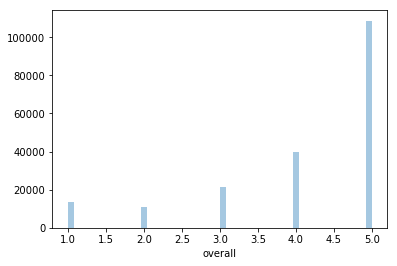

In [25]:
sns.distplot(df['overall'],kde=False)

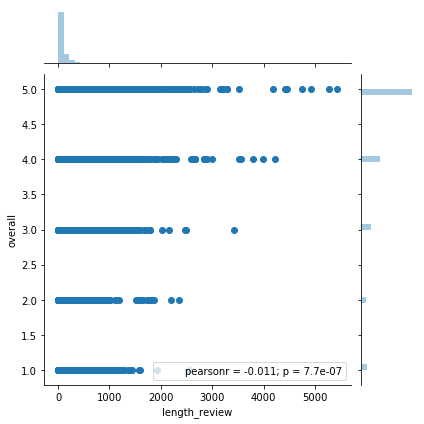

In [26]:
sns.jointplot(x='length_review',y='overall',data=df)

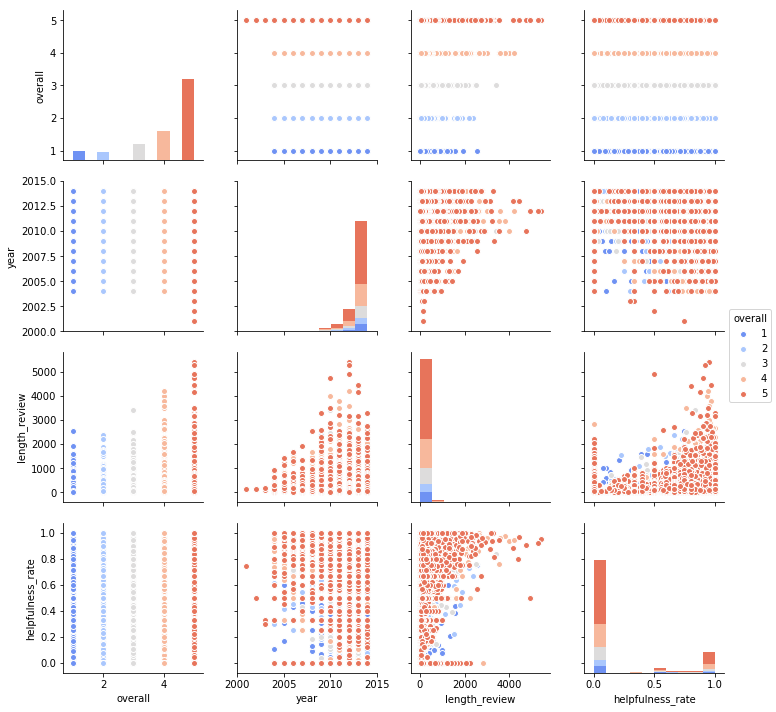

In [27]:
sns.pairplot(df,hue='overall',palette='coolwarm')

# References

[1] https://github.com/sourabhlal/ada2017/blob/master/Project/Main_Notebook_Amazon.ipynb